# Stahl et al data preparation

Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from scipy.stats import ttest_ind

## Read data from Stahl et al.

In [20]:
data_spe = pd.read_csv('data/data_spe.csv')
data_spe.head()

,subj_idx,rt,response,type,pre_Ne,pre_Pe
0,1,0.260,0,correct,11.804409,-12.455902
1,1,0.454,1,error,8.926700,7.533589
2,1,0.746,1,correct,7.569110,-4.754229
3,1,0.470,1,correct,-16.353251,2.955482
4,1,0.456,0,correct,-2.223574,3.389713


In [21]:
def standardize(series):
    return series  / series.std()

data_spe['pre_Ne_standarized'] = data_spe.groupby('subj_idx')['pre_Ne'].transform(standardize)
data_spe['acc'] = [-1 if response == 0 else 1 for response in data_spe['response']]
data_spe['pre_response'] = [-1 if type == 'error' else 1 for type in data_spe['type']]
data_spe['y'] = data_spe['rt'] * data_spe['acc']

In [22]:
data_spe.head()

,subj_idx,rt,response,type,pre_Ne,pre_Pe,pre_Ne_standarized,acc,pre_response,y
0,1,0.260,0,correct,11.804409,-12.455902,0.935791,-1,1,-0.260
1,1,0.454,1,error,8.926700,7.533589,0.707662,1,-1,0.454
2,1,0.746,1,correct,7.569110,-4.754229,0.600039,1,1,0.746
3,1,0.470,1,correct,-16.353251,2.955482,-1.296399,1,1,0.470
4,1,0.456,0,correct,-2.223574,3.389713,-0.176273,-1,1,-0.456


In [23]:
data_spe.groupby('subj_idx').describe()['rt']

,count,mean,std,min,25%,50%,75%,max
subj_idx,,,,,,,,
1,97.0,0.340103,0.118813,0.160,0.24600,0.302,0.4300,0.746
2,117.0,0.464709,0.085466,0.252,0.40600,0.464,0.5200,0.696
3,287.0,0.475296,0.100563,0.298,0.40700,0.466,0.5240,0.936
4,325.0,0.531197,0.096484,0.342,0.46800,0.518,0.5760,0.908
5,134.0,0.574448,0.201097,0.274,0.44425,0.534,0.6720,1.286
...,...,...,...,...,...,...,...,...
61,112.0,0.579366,0.173950,0.204,0.46400,0.580,0.6890,1.068
62,77.0,0.369571,0.145939,0.112,0.26000,0.368,0.4660,0.832
63,137.0,0.444533,0.139956,0.222,0.33000,0.432,0.5300,0.884


Prepare json file for Stan

In [24]:
y = data_spe['y'].to_list()
pre_acc = data_spe['pre_response'].to_list()
pre_ne = data_spe['pre_Ne_standarized'].to_list()
unique_ids = data_spe['subj_idx'].unique()
id_mapping = {original_id: new_id for new_id, original_id in enumerate(unique_ids, start=1)}
data_spe['participant_idx'] = data_spe['subj_idx'].map(id_mapping)

participant_index = data_spe['participant_idx'].to_list()

n_participants = len(np.unique(participant_index))
n_conditions = 1
condition = list(np.ones((len(participant_index),)))
participants_trials_slices = []
for index in np.unique(participant_index):
    indices = np.where(participant_index == index)[0]
    start_index = int(indices[0] + 1)
    end_index = int(indices[-1] + 1)
    participants_trials_slices.append([start_index, end_index])



In [25]:
data_2d = {
    "N": len(y),
    "participants_trials_slices": participants_trials_slices,
    "n_conditions": n_conditions,
    "n_participants": n_participants,
    "y": y,
    "condition": condition,
    'pre_ne': pre_ne,
    'pre_acc': pre_acc,
    "participant": participant_index
}

In [18]:
np.unique(participant_index)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89])

Save data to json

In [26]:
with open("data/stahl_spe_data_standarized.json", "w") as outfile: 
    json.dump(data_2d, outfile)

## Analyse data

### Post-error adaptation in RTs

<Axes: xlabel='rt', ylabel='Count'>

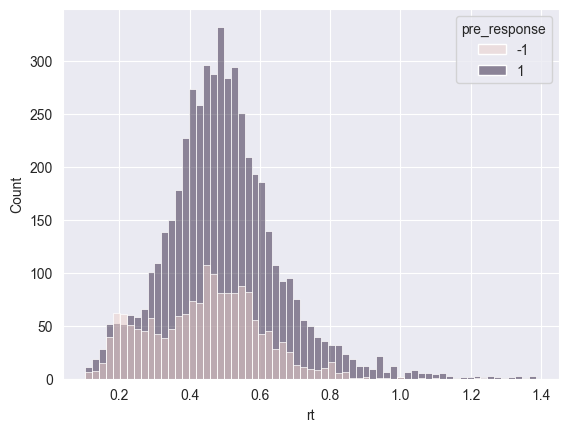

In [6]:
sns.histplot(
    data_spe,
    x='rt',
    hue='pre_response',
)

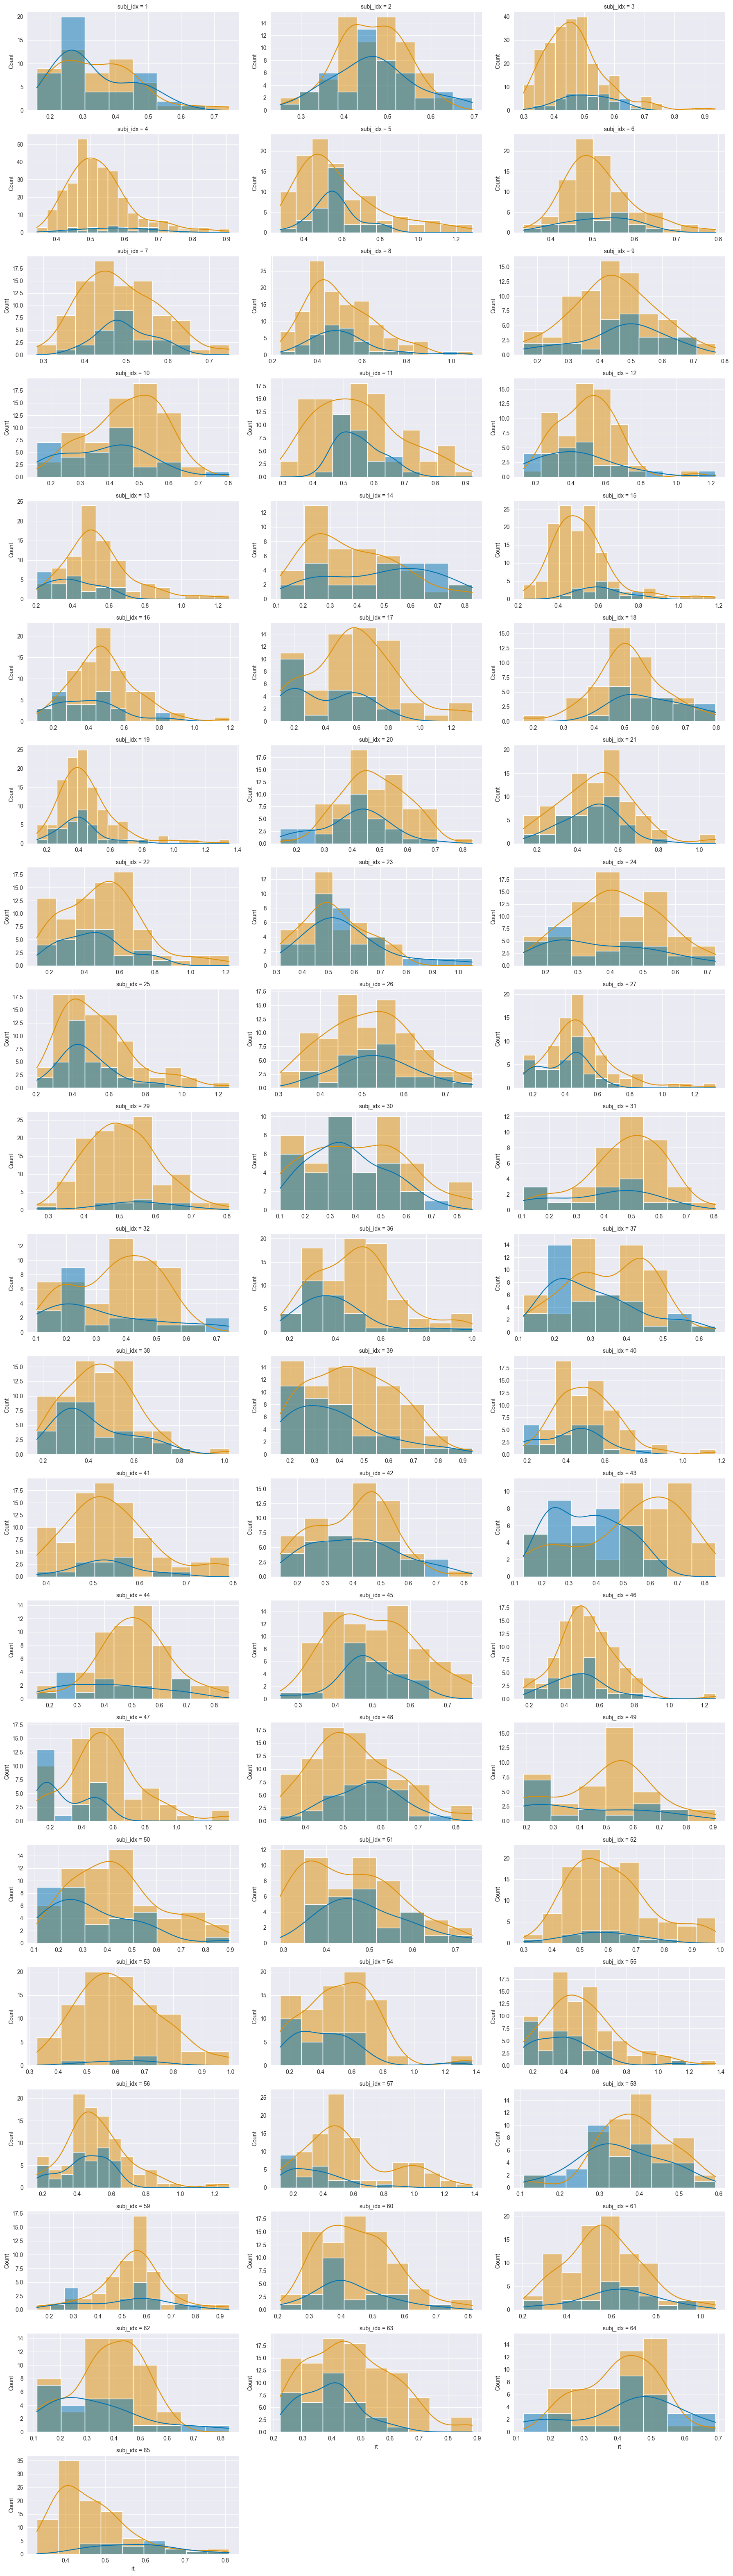

In [9]:
g = sns.FacetGrid(
    data_spe.sort_values(['subj_idx']),
    col="subj_idx",
    col_wrap=3,
    sharex=False,
    sharey=False,
    aspect=2,
)

g.map_dataframe(
    sns.histplot,
    x="rt",
    hue='pre_response',
    kde=True,
    palette='colorblind'
)

In [7]:
print(f"Mean post error RT: {np.mean(data_spe[data_spe['pre_response'] == -1]['rt'])}")
print(f"Mean post correct RT: {np.mean(data_spe[data_spe['pre_response'] == 1]['rt'])}")

Mean post error RT: 0.4435980221058755
Mean post correct RT: 0.4960447585394582


In [8]:
print(f"post error vs post correct : {ttest_ind(data_spe[data_spe['pre_response'] == -1]['rt'], data_spe[data_spe['pre_response'] == 1]['rt'])}")

post error vs post correct : TtestResult(statistic=-11.325461761211969, pvalue=1.7988216576830153e-29, df=6811.0)


#### Test the difference in EEG between post-error and post-correct

Group-level stats and distributions

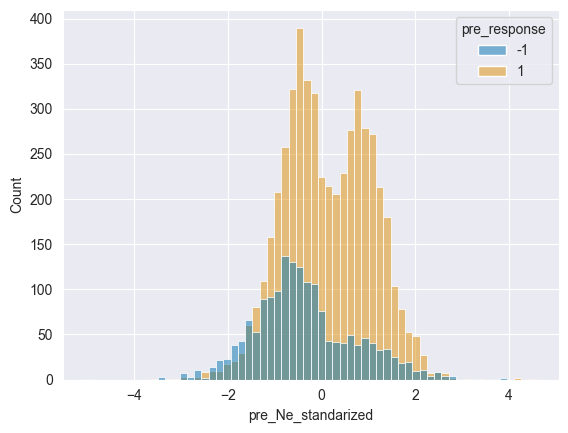

In [32]:
plt.figure()

sns.histplot(
    data_spe,
    x="pre_Ne_standarized",
    hue='pre_response',
    palette='colorblind'
)

plt.show()

In [33]:
ttest_ind(
    data_spe[data_spe['pre_response'] == -1]['pre_Ne_standarized'], 
    data_spe[data_spe['pre_response'] == 1]['pre_Ne_standarized']
)

TtestResult(statistic=-18.438485300654015, pvalue=4.01515566551647e-74, df=6811.0)

Participant-level stats and distributions

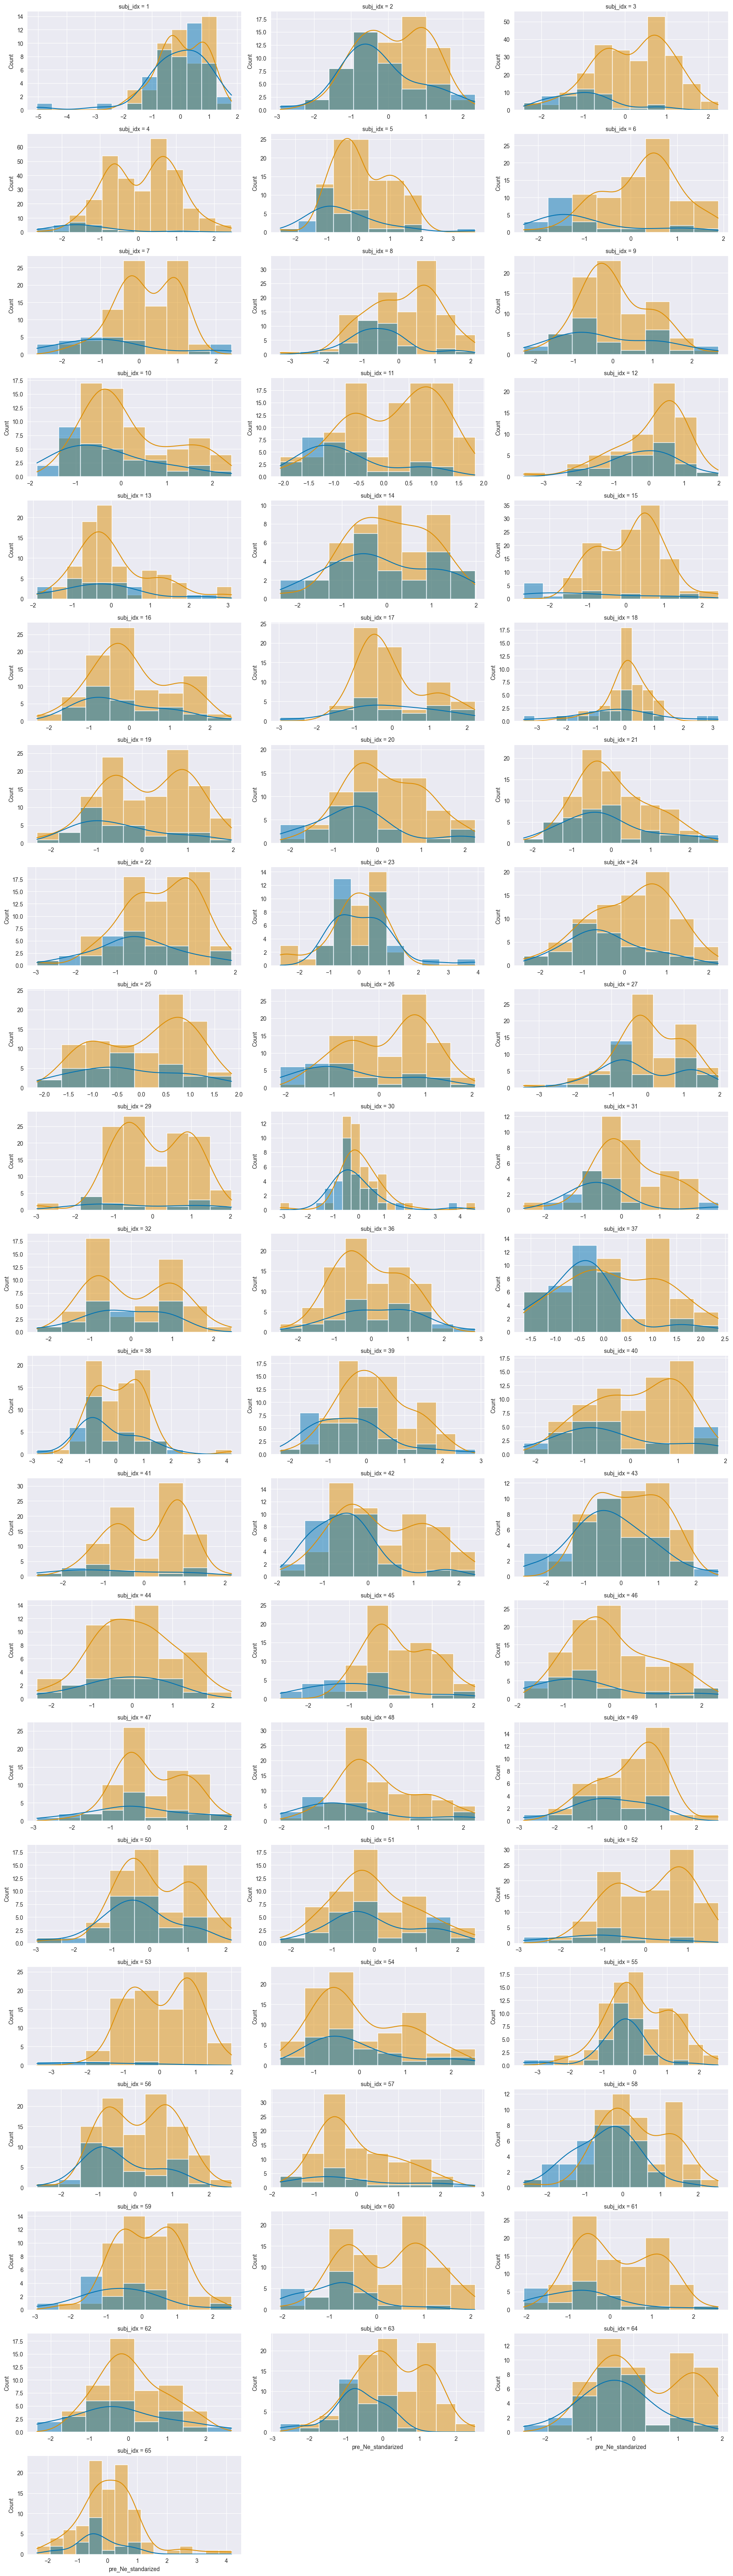

In [34]:
g = sns.FacetGrid(
    data_spe.sort_values(['subj_idx']),
    col="subj_idx",
    col_wrap=3,
    sharex=False,
    sharey=False,
    aspect=2,
)

g.map_dataframe(
    sns.histplot,
    x="pre_Ne_standarized",
    hue='pre_response',
    kde=True,
    palette='colorblind'
)

#### Test post-response adaptation and links with pre-trial accuracy and brain signal

In [37]:
import statsmodels.formula.api as smf

mod = smf.ols(formula='rt ~ pre_Ne_standarized*pre_response', data=data_spe)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     rt   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     59.21
Date:                Mon, 22 Apr 2024   Prob (F-statistic):           8.86e-38
Time:                        16:07:58   Log-Likelihood:                -91533.
No. Observations:                6813   AIC:                         1.831e+05
Df Residuals:                    6809   BIC:                         1.831e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 